In [8]:
# Libraries used

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

## **Group Project**
### Group Number: 15
### Group Member Names: Aiden Suh, Samuel Zhang, Vincent He Zhen
### Group Strategy: Beat the Market(the market is defined here as the arithmetic average between the return of each index for the TSX 60 and the S&P 500 over a certain period)

# **Diversification/Risk management:**

When trying to beat the market, we do not want to diversify into different stocks or industries as much, as that will provide the greatest opportunity for a high rate of returns despite being in high non-systematic risk. Such an analysis indicates that the portfolio will be biased towards specific industries or groups of stocks that are similarly correlated. We will also invest in the minimum number of distinct stocks required (12) to maximize our potential returns while putting as much weight into the highest-performing stocks as possible. All in all, bearing this extra risk is necessary to beat the market.

# **Weightings:**

By applying different weightings to our indicators, we are able to quantitatively measure the best stocks to invest in, in order to beat the market. Weightings totaling 100% will be split between our indicators (Ex. Indicator 1 gets 40%, indicator 2 gets 20%, and indicator 3 gets 40%), which will be multiplied by their scores between 0 to 1 concerning that indicator. Finally, the scores from each indicator are added up with the maximum theoretical final score being 1, with the lowest being 0.

For example, if a stock achieves 0.5 on indicator 1, 1 on indicator 2, and 0 on indicator 3, its final score would be:

(0.5 * 0.4) + (1 * 0.2) + (0 * 0.4) = 0.4

# **Data Filtering - Retrieve Only Valid Stocks From The .csv File**
The following algorithm scans the given .csv file and apply a filter function to filter following:
- Tickers that do not reference a valid stock denominated in either USD or CAD
- Stocks that have less than an average monthly volume of at least 100,000 shares from October 01, 2023 to September 30, 2024
- Stocks that either didn't IPO or IPO'd after the analysis start date (2024-01-01).

In addition to the basic filtering requirement, we also decided to filter out any stocks that did not IPO before our initial starting date for the analysis information. This is because our investment strategies rely on a full year's worth of data, and we need to ensure that all stocks in the portfolio have a consistent and complete set of historical data over the entire analysis period to accurately assess their performance and contribution to the portfolio. Including stocks with incomplete data due to a recent IPO could introduce bias or distort the portfolio's performance metrics, as those stocks would not have a full performance history for comparative evaluation.

In [24]:
# extract data
data = pd.read_csv('Tickers.csv')

# if the first ticker is incorrectly made into a column, we need to append that ticker to first
extra_ticker = data.columns[0]
if extra_ticker not in data.iloc[:, 0].tolist():
    data = pd.concat([pd.DataFrame([[extra_ticker]], columns=data.columns), data], ignore_index=True)

# initialization of interval variables for data analysis later on
start_date = '2024-01-01'
end_date = '2024-11-23'

# Aiden's Algorithm to filter stocks
def filter_data(data):
    filtered_data = []
    ticker_symbols = data.iloc[:, 0].tolist()  # puts all ticker symbols into a list first

    for symbol in ticker_symbols:
        try:
            ticker = yf.Ticker(symbol)

            if ticker.info and ticker.info.get('currency') in ['CAD', 'USD']: # checks if currency is either in CAD or USD
                ticker_history = ticker.history(start='2023-10-01', end='2024-10-01')

                # if no data is available for the ticker, filter that symbol
                if ticker_history.empty:
                    continue

                # check if the stock has IPO'd, or if it did, check if the stock IPO'd after our start date for the analysis
                first_valid_date = ticker_history.first_valid_index()
                if first_valid_date is None:
                    continue
                else:
                    if pd.Timestamp(first_valid_date).tz_localize(None) > pd.to_datetime(start_date).tz_localize(None):
                        continue

                # check if the ticker data includes its volume info
                if 'Volume' in ticker_history.columns:
                    ticker_history.index = pd.to_datetime(ticker_history.index)
                    monthly_data = ticker_history['Volume'].resample('ME').agg(sum='sum', count='count')
                    valid_months = monthly_data[monthly_data['count'] >= 18] # filters any month with less than 18 trading days

                    if not valid_months.empty:
                        monthly_avg_volume = valid_months['sum'] / valid_months['count']

                        if monthly_avg_volume.mean() >= 100000: # checks if the stock has an average monthly volume of at least 100,000 shares
                            filtered_data.append(symbol) # only when every requirement is fulfilled, add the symbol to filtered list

        except Exception as e:
            print(f"An error occurred: {e}")

    return filtered_data

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ASDFAASDF.TO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ASDFAASDF.TO&crumb=oGwL4dkKqCX
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/INVALIDTIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=INVALIDTIC&crumb=oGwL4dkKqCX
$AW.TO: possibly delisted; no price data found  (1d 2023-10-01 -> 2024-10-01) (Yahoo error = "Data doesn't exist for startDate = 1696132800, endDate = 1727755200")


32


# **INDICATOR 1: Correlation Between the Market and Each Stock**

We will use the built-in function \.pct_change() to calculate the daily percentage change of each stock since Jan 1, 2024. This ensures there is sufficient data for our algorithm to and minimizes random errors or days that are outliers. The average daily percent change of the TSX and S&P500 represents the market's daily percent change. Thus, we can use the \.corr() built-in function to determine how each stock individually correlates to the market. Since we wish to beat the market, we ideally want to invest in stocks that have a low correlation with the market. This is because a low correlation implies that a stock will deviate greatly from the market, giving it a higher chance of beating the market. However, this is risky since our portfolio could increase or decrease a lot in value; we can't be sure which way in the future.

The correlation indicator was given the highest weighting of 40% because we believe it is the most important. Correlation allows us to directly compare the relationship between the market and a share, unlike other indicators.

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ASDFAASDF.TO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ASDFAASDF.TO&crumb=oGwL4dkKqCX
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/INVALIDTIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=INVALIDTIC&crumb=oGwL4dkKqCX
$AW.TO: possibly delisted; no price data found  (1d 2023-10-01 -> 2024-10-01) (Yahoo error = "Data doesn't exist for startDate = 1696132800, endDate = 1727755200")
[*********************100%***********************]  2 of 2 completed
C:\Users\aiden\AppData\Local\Temp\ipykernel_15372\1790012222.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any no

,AAPL,ABBV,LOW,HOOD,AMZN,AXP,BAC,BK,SQ,VZ,...,OXY,DUOL,PEP,T.TO,SLB,SO,SPG,SHOP.TO,RY.TO,TD.TO
0,0.350849,0.462995,0.277639,0.2879,0.246356,0.257159,0.247129,0.244945,0.260302,0.461272,...,0.310247,0.31789,0.498676,0.418833,0.278427,0.480877,0.282536,0.290136,0.199195,0.286345


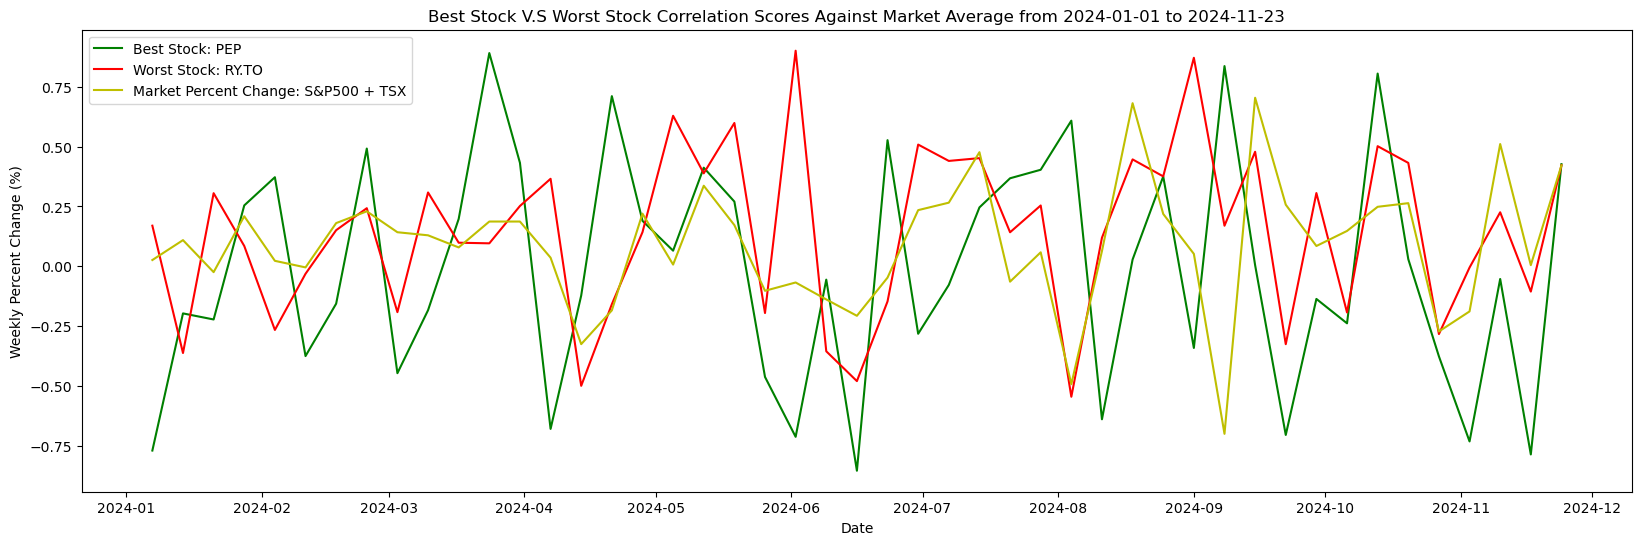

In [21]:
# Vincent's Algorithm to find the 12 most correlated stocks in the csv file

# Filter the stocks
data_filter = filter_data(data)

# Initialization
ticker_name = ""
data_close = pd.DataFrame()

for i in range (0,len(data_filter)):
  ticker_name = data_filter[i]

  ticker1 = yf.Ticker(ticker_name)
  ticker1_hist = ticker1.history(start=start_date, end=end_date)

  # if the ticker is delisted or not available, then don't add it to data_close
  if (not ticker1_hist.empty):
    ticker1_hist.index = pd.to_datetime(ticker1_hist.index).strftime('%Y-%m-%d')

    data_close[ticker_name]=ticker1_hist['Close']

# Find the average percent change for the S%P500 and TSX which represent the market
data_market = yf.download(["^GSPC", "^GSPTSE"], start=start_date, end=end_date)['Close']
data_market.index = data_market.index.strftime('%Y-%m-%d')

# Calculate the average of S&P 500 and TSX closing prices, and create a one-column dataframe
market_close = (data_market["^GSPC"] + data_market["^GSPTSE"])/2
market_close = pd.DataFrame(market_close, columns=["Average"])
market_close_pct = market_close.pct_change()
market_close_pct.drop(index=market_close_pct.index[0], inplace=True)

# Creating a dataframe for percent returns
data_pct = data_close.pct_change()
# drop the NaN values
data_pct.drop(index=data_pct.index[0], inplace=True)

# Add the market average to the data_pct
data_pct['Average'] = market_close_pct['Average']


# Determining the correlation between the market and each stock, with the lowest correlation being the best
# Initialization
corr = 0
data_corr_score = pd.DataFrame()

best_score_so_far = 0
worst_score_so_far = 1

best_stock_so_far = ""
worst_stock_so_far = ""

# Loop through all columns, except for the 'Average' column
for col in data_pct.columns:
  if col != 'Average':
    corr = data_pct['Average'].corr(data_pct[col])

    # correlation is adjusted to a scale of 0 to 1, then subtracted by 1
    # since we want the lowest correlation in order to beat the market
    corr_score = (1-((corr + 1)/2))
    data_corr_score.at[0, col] = corr_score

    # Keep track of the best and worst stocks for graphing purposes
    if corr_score >= best_score_so_far:
      best_stock_so_far = col
      best_score_so_far = corr_score

    if corr_score <= worst_score_so_far:
      worst_stock_so_far = col
      worst_score_so_far = corr_score


# We can use best_stock_so_far, worst_stock_so_far to graph the data

# Convert to datatime
data_close_dt = data_pct
data_close_dt.index = pd.to_datetime(data_close_dt.index)

# Convert to weekly data, so it fits into a graph, allowing for easier analysis
weekly_pct = data_close_dt.resample('W').mean()
weekly_pct = weekly_pct * 100 # changing to percentage


# Size
plt.figure(figsize=(20, 6))

# Create Plot
plt.plot(weekly_pct.index,weekly_pct[best_stock_so_far], color='g', label="Best Stock: "+best_stock_so_far)
plt.plot(weekly_pct.index,weekly_pct[worst_stock_so_far], color='r', label="Worst Stock: " +worst_stock_so_far)
plt.plot(weekly_pct.index,weekly_pct['Average'], color='y', label= "Market Percent Change: S&P500 + TSX")

#Labels and Title
plt.legend(loc='best')
plt.title('Best Stock V.S Worst Stock Correlation Scores Against Market Average from '+ start_date + ' to '+ end_date)
plt.xlabel('Date')
plt.ylabel('Weekly Percent Change (%)')

# Output
display(data_corr_score)
plt.show()

Best Stock vs. Worst Stock Graph:

As shown above, the best stock should be the least correlated with the market percent change, while the worst stock should be positively correlated with the market percent change. Potentially, there are weeks where the best stock is in fact negatively correlated with the market percent change, where the stock would increase or decrease opposite to the market. Weekly data was used to make the graph easier to interpret, but some data may be lost.

# **INDICATOR 2: Implied Volatility(IV) ranking**
IV is the market's forecast of a stock's future volatility, measured on an annualized basis.

To find the market's predicted volatility of a stock, we can take the yfinance Implied Volatility column for a particular option type and expiry date.
  
Implied volatility is calculated by inputting an option price into the BSM and then backing out the IV, but since yfinance does this for us it simplifies the math.

This means that IV can also change from market demand. If option prices increase (meaning more people are buying), that automatically increases the IV output from the BSM as it indicates the market is expecting a large upcoming movement.

We will use IV to forecast the future risk of each stock, which therefore corresponds to a possibility of higher returns. Even though volatility is not exactly the same as standard deviation, they are both still measures of risk. Therefore, a high score in this indicator means that the market is forecasting the stock to have a large movement compared to the others.

Since we are dealing with a short-term investment window, we will take the average of 3 calls and put contracts or 6 total contracts. For both the calls and puts, one will be at the money, and the other two will be just slightly above and below the ATM strike price. This is to ensure that a wider array of an IV is taken into account, not just the IV at a single price point. The contracts will all be dated to expire on November 29, 2024, so that we can get a gauge of the IV for the particular period in which we are competing. If no such maturity date exists, we will simply take the maturity date closest to the current date.

Since yfinance only shows options data for American stocks, in the case that a stock does not have options data, the IV's indicator weight will be shifted to the other indicators.

We decided to assign IV a weighting of 20%, as it's important to know market sentiment on a stock but it's not as important as correlation.

In [22]:
# Samuel's Algorithm to calculate IVs.

# Produces the strike prices for 3 options as detailed above in the markdown.
def get_strike_prices(ticker, underlying_price, expiration_date, is_call):
    # Separate calls and puts.
    if is_call:
        options = ticker.option_chain(expiration_date).calls
    else:
        options = ticker.option_chain(expiration_date).puts

    # Take the option's strike prices.
    strike_prices = options["strike"].tolist()
    strike_prices.sort()
    min_list = []

    # Take the distance between each strike and the underlying stock's price to find
    #   the option closest to being at the money.
    for strike_price in strike_prices:
        min_list.append(abs(underlying_price - strike_price))

    position = min_list.index(min(min_list))
    atm_strike = strike_prices[position]

    # We take the options one price level above and below our ATM option.
    below_atm_strike = strike_prices[position - 1]
    above_atm_strike = strike_prices[position + 1]

    return [below_atm_strike, atm_strike, above_atm_strike]

# Produces a DataFrame that scores each stock's IV data.
def get_iv_scores(ticker_list):
    data_iv_score = pd.DataFrame()

    call_iv = []
    put_iv = []

    # Loop through each ticker and get the options data for each strike price we get from
    #   the get_strike_prices function.
    for ticker_symbol in ticker_list:
        expiration_date = "2024-11-29"
        ticker = yf.Ticker(ticker_symbol)

        # If the stock doesn't have options data, give it a None value
        if ticker.options:
            last_quote = ticker.info.get("currentPrice")

            # If the stock doesn't have any options expiring on our optimal date we take the
            #   earliest expiration.
            if expiration_date not in ticker.options:
                expiration_date = ticker.options[0]

            call_strikes = get_strike_prices(ticker, last_quote, expiration_date, is_call=True)
            put_strikes = get_strike_prices(ticker, last_quote, expiration_date, is_call=False)
            options = ticker.option_chain(expiration_date)

            for call_strike, put_strike in zip(call_strikes, put_strikes):
                cur_iv = options.calls[options.calls['strike'] == call_strike]["impliedVolatility"]
                call_iv.append(cur_iv)

                cur_iv = options.puts[options.puts['strike'] == put_strike]["impliedVolatility"]
                put_iv.append(cur_iv)

            # Take the average of our IVs and add it into our DataFrame.
            avg_iv = np.mean(call_iv + put_iv)
            data_iv_score.loc[0, ticker_symbol] = avg_iv

        else:
            data_iv_score.loc[0, ticker_symbol] = None

    # Use min-max normalization to set the values to be in between 0 and 1, 0 being the
    # worst performing stock and 1 being the highest.
    min_score = data_iv_score.iloc[0].min()
    max_score = data_iv_score.iloc[0].max()

    data_iv_score = (data_iv_score - min_score) / (max_score - min_score)

    return data_iv_score


data_iv_score = get_iv_scores(data_filter)
data_iv_score

,AAPL,ABBV,LOW,HOOD,AMZN,AXP,BAC,BK,SQ,VZ,...,OXY,DUOL,PEP,T.TO,SLB,SO,SPG,SHOP.TO,RY.TO,TD.TO
0,0.0,0.089431,0.07338,1.0,0.947727,0.829289,0.723932,0.756396,0.914249,0.839844,...,0.649477,0.733957,0.701382,NaN,0.708651,0.684052,0.672828,NaN,NaN,NaN


# **INDICATOR 3: Exponential Moving Average(EMA) Ranking**
We will add a bit of technical analysis (TA) to factor in price trends and patterns. While TA is not the end-all-be-all for choosing stocks, it is still worthwhile to analyze what trends there are in the price movement. We will use a strategy focused on the Moving Average Convergence/Divergence, or MACD.

We start by constructing 3 exponential moving average (EMA) lines: the 12, 26, and 200-day EMAs. These are simply calculated by adding up the data points for a specific range of days before a particular date (in our case 12, 26, and 200) and then dividing by the number of data points. The EMA differs in that it places more weight on dates closer to the present day, but this math is all handled by the pandas .ewm function.

When we take the difference between the 12 and 26 EMA lines, we get the MACD line. When the MACD is positive (12-day EMA > 26-day EMA), it generally signals an upward price movement, and vice versa.

We will combine looking for stocks with positive recent MACD lines with the 200-day EMA being below the stock's stock price. When the 200-day EMA is below the stock price it is another indicator that the stock is in an upward trend. We want to see when both the MACD is positive and the difference between stock price and 200-day EMA is positive as can be seen in the graph below for AAPL. Even though the 200-day EMA is below the stock price for more recent dates, the MACD line is hovering around 0, and we can see that the actual stock price is more or less stagnating. Whereas when the indicators aligned in June-July 2024, the stock price rallied.

Our code will combine these 2 elements together to rank our list of eligible stocks.

We decided to assign EMA a weighting of 20%. Technical indicators have their place, but they shouldn't be overly influential in picking stocks.

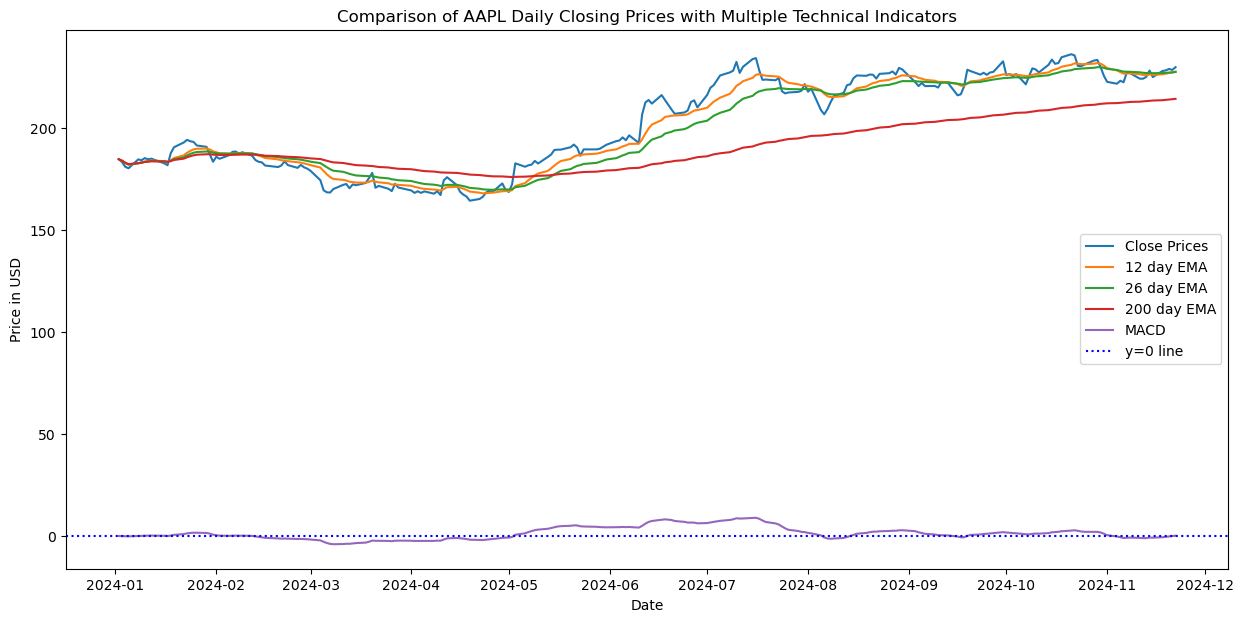

In [12]:
# EMA test for AAPL
aapl = yf.Ticker("AAPL")
aapl_hist = aapl.history(start=start_date, end=end_date)

# The pandas .ewm function takes in the number of available data points before each point
#   up to the span value. This is why for the initial values of the EMA lines they look similar,
#   but then the further the dates go the more they diverge and have more past data to work with.
aapl_hist['EMA_12'] = aapl_hist["Close"].ewm(span=12).mean()
aapl_hist['EMA_26'] = aapl_hist["Close"].ewm(span=26).mean()
aapl_hist['EMA_200'] = aapl_hist["Close"].ewm(span=200).mean()

aapl_hist["MACD"] = aapl_hist['EMA_12'] - aapl_hist['EMA_26']

plt.figure(figsize=(15, 7))

plt.plot(aapl_hist["Close"], label="Close Prices")
plt.plot(aapl_hist["EMA_12"], label="12 day EMA")
plt.plot(aapl_hist["EMA_26"], label="26 day EMA")
plt.plot(aapl_hist["EMA_200"], label="200 day EMA")
plt.plot(aapl_hist["MACD"], label="MACD")
plt.axhline(y = 0, color = 'b', linestyle = 'dotted', label="y=0 line")

plt.title("Comparison of AAPL Daily Closing Prices with Multiple Technical Indicators")
plt.ylabel("Price in USD")
plt.xlabel("Date")

plt.legend()

In [13]:
# Samuel's Algorithm to produce a score for each stock based on how their technicals perform in the strategy outlined above.
def get_ema_scores():
    data_ema_score = pd.DataFrame()
    ticker_hist = pd.DataFrame()

    # For every valid ticker, get the historical data and construct the technical indicators.
    for ticker_symbol in data_close.columns.values.tolist():
        ticker_hist["Close"] = data_close.loc[:, ticker_symbol]

        ticker_hist['EMA_12'] = ticker_hist["Close"].ewm(span=12).mean()
        ticker_hist['EMA_26'] = ticker_hist["Close"].ewm(span=26).mean()
        ticker_hist["MACD"] = ticker_hist['EMA_12'] - ticker_hist['EMA_26']
        ticker_hist["EMA_200"] = ticker_hist["Close"].ewm(span=200).mean()

        # Consider the last 10 trading days to target stocks in a recent upturn
        ticker_hist_last_10 = ticker_hist.iloc[-10:].copy()
        for date in ticker_hist_last_10.index.tolist():
            # Calculate the score by adding the 200 day EMA to the product of 200 day EMA and MACD, keeping into
            #   account the negatives.
            ema_200_diff = (ticker_hist.loc[date, "Close"] - ticker_hist.loc[date, "EMA_200"])

            if ticker_hist.loc[date, "MACD"] < 0 and ema_200_diff < 0:
                ticker_ema_score = (ema_200_diff - (ema_200_diff * ticker_hist.loc[date, "MACD"])) / ticker_hist.loc[date, "Close"]
            else:
                ticker_ema_score = (ema_200_diff + ema_200_diff * ticker_hist.loc[date, "MACD"]) / ticker_hist.loc[date, "Close"]

            data_ema_score.loc[0, ticker_symbol] = ticker_ema_score

    # Standardize the data to between 0 and 1 using min-max again.
    min_score = data_ema_score.iloc[0].min()
    max_score = data_ema_score.iloc[0].max()

    data_ema_score = (data_ema_score - min_score) / (max_score - min_score)

    return data_ema_score

data_ema_score = get_ema_scores()
data_ema_score

,AAPL,ABBV,LOW,HOOD,AMZN,AXP,BAC,BK,SQ,VZ,...,OXY,DUOL,PEP,T.TO,SLB,SO,SPG,SHOP.TO,RY.TO,TD.TO
0,0.051407,0.004997,0.040605,0.320052,0.083003,0.251834,0.105933,0.111402,0.346683,0.046228,...,0.015472,1.0,0.0,0.028732,0.03207,0.041725,0.126175,0.727654,0.083503,0.034612


# **INDICATOR 4: Sharpe Ratio Ranking**

For this indicator, **TWO** factors are considered:
1. Individual Sharpe ratios for each stock(portfolios made of only one stock)
2. Generation of a large number of random portfolio weight combinations(one million) and the best Sharpe ratio among all

First, it generates a list of portfolios made up only of each given stock and calculates all of their Sharpe ratios based on historical performance to measure the risk-adjusted return for each stock individually. This serves as a baseline for each stock's performance without taking the concept of diversification, making it easier to compare them individually. This step also ensures that individually poorly performing stocks with negative or low Sharpe ratios can be identified and potentially excluded from further analysis with the next step. But stocks with individually high Sharpe ratios don't necessarily lead to the best overall portfolio, especially when each of them is highly correlated with others. It also fails to account for how stocks interact with one another in a portfolio, which could be disadvantageous in a situation where we have to choose at least 12 stocks to form a portfolio.

The second factor takes into account how each stock would perform in a portfolio context; it generates a portfolio that consists of all stocks with random weighting a million times, calculates all of their Sharpe ratios based on historical data, catches the portfolio that yields the best Sharpe ratio and the weightings of each stock in that particular portfolio. That way, we can see which stocks contributed how much to form a portfolio with the highest Sharpe ratio. It then multiplies the individual Sharpe ratios and weightings in the combined portfolio for each stock to calculate their "score," and standardizes performance scores to fall between 0 and 1, so the highest performing stock gets assigned 1, and the poorest performing gets assigned 0, and every others to fall in between. This step takes diversification into account and helps identify the weighting combination that maximizes the Sharpe ratio. However, since the weighting depends on randomness, it may overweight poorly performing stocks with high volatility if they contribute positively to the overall diversification. Such a problem gets resolved when the steps are combined though, as the first step will catch stocks with negative or low Sharpe ratios. Additionally, risk free rate needed to calculate sharpe ratios is set to 4%, which reflects a reasonable benchmark given current market conditions.

We decided to assign the Sharpe Ratio a weighting of 20%, recognizing its value in diversification even in risky strategies but ensuring it doesn't dominate stock selection.

[*********************100%***********************]  30 of 30 completed


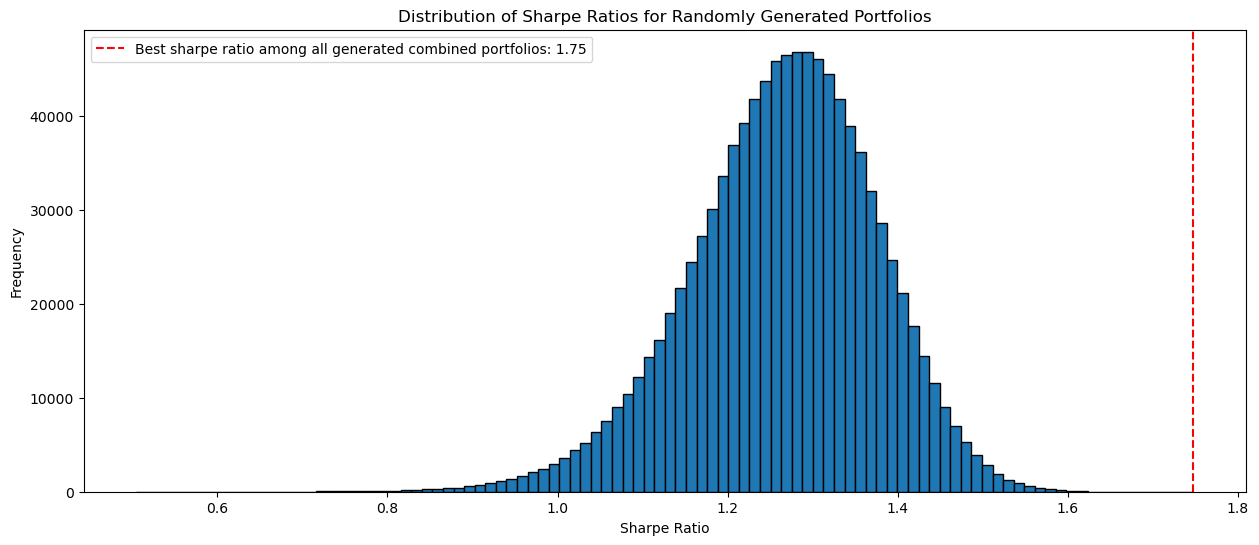

,AAPL,ABBV,AMZN,AXP,BAC,BK,CMCSA,COST,CSCO,CVS,...,RY.TO,SHOP,SHOP.TO,SLB,SO,SPG,SQ,T.TO,TD.TO,VZ
Weight In Combined Portfolio With Highest Sharpe Ratio(%),0.445770,7.665081,2.747759,6.190139,6.792493,1.443176,0.815298,5.340129,1.100281,0.248591,...,3.352566,0.017092,3.114499,6.000159,0.482391,1.408177,1.823585,6.405029,6.577139,6.733011
Individual Portfolio Sharpe Ratio,0.748774,1.337419,2.379988,1.859747,1.356545,1.289656,-1.333752,1.933192,-0.191611,-1.927127,...,0.980300,0.027830,0.192828,-1.316235,0.973783,1.028574,-0.304071,-1.483665,-1.937251,1.425458
Standardized Performance Score,0.524958,0.923138,0.774115,0.973752,0.881500,0.586282,0.467899,0.926032,0.503093,0.492323,...,0.643506,0.511576,0.535669,0.194478,0.530417,0.569709,0.489295,0.130027,0.000000,0.896889


In [27]:
# Function to display the graph for Aiden's Sharpe Ratio Algorithm example
def display_ratio_graph(stocks):

    starting_cash = 1000000
    risk_free_rate = 0.04
    num_tested_portfolios = 1000000  # set the number of random portfolios to be tested high(one million) to improve the accuracy of random sampling by CLT
    # Central Limit Theorem(CLT) says that the sampling distribution of the mean will always be normally distributed, as long as the sample size is large enough

    # retrieve closing data for all stocks
    stock_data = yf.download(stocks, start=start_date, end=end_date)['Close']

    # NEW CODE: filter only the stocks with valid data
    stocks = stock_data.columns.tolist()

    # create portfolios for individual stocks & calculate their sharpe ratios to measure individual performances
    individual_portfolios = (starting_cash / stock_data.iloc[0]) * stock_data
    individual_pct_return = ((individual_portfolios - individual_portfolios.iloc[0]) /  individual_portfolios.iloc[0]) * 100
    individual_exp_return = individual_pct_return.mean(axis=0)
    individual_std_devs = individual_pct_return.std(axis=0)
    individual_sharpe_ratios = (individual_exp_return - risk_free_rate) / individual_std_devs

    # generate random weights for each stocks which add up to 100%
    weights = np.random.random((num_tested_portfolios, len(stocks)))
    weights /= weights.sum(axis=1)[:, np.newaxis]

    # using individual portfolios and random weights to generate test portfolios & calculate their sharpe ratios
    combined_portfolios = individual_portfolios.dot(weights.T)
    combined_pct_returns = ((combined_portfolios - combined_portfolios.iloc[0]) / combined_portfolios.iloc[0]) * 100
    combined_expected_returns = combined_pct_returns.mean(axis=0)
    combined_std_devs = combined_pct_returns.std(axis=0)
    combined_sharpe_ratios = (combined_expected_returns - risk_free_rate) / combined_std_devs

    # find the combined portfolio with the best sharpe ratio & store weights of each stocks for the highest ratio
    best_idx = combined_sharpe_ratios.argmax()
    best_weights = weights[best_idx] * 100
    best_sharpe = combined_sharpe_ratios[best_idx]

    # using individual portfolios' sharpe ratios and weightings of stocks in the
    # combined portfolio with highest sharpe ratio to get each stock's overall "score"
    performance_scores = pd.Series(best_weights, index=stocks) * (pd.Series(individual_sharpe_ratios, index=stocks))

    # standardize the performance scores between 0 and 1
    min_score = performance_scores.min()
    max_score = performance_scores.max()
    standardized_scores = (performance_scores - min_score) / (max_score - min_score)

    # create a df with individual performances, weights of stocks in best combined portfolio, and performance scores
    optimal_weights_df = pd.DataFrame([best_weights, individual_sharpe_ratios, standardized_scores], columns=stocks)
    optimal_weights_df.index=['Weight In Combined Portfolio With Highest Sharpe Ratio(%)', 'Individual Portfolio Sharpe Ratio', 'Standardized Performance Score']

    # graph the distribution of sharpe ratios
    plt.figure(figsize=(15, 6))
    plt.hist(combined_sharpe_ratios, bins=100, edgecolor='black')
    plt.axvline(best_sharpe, color='red', linestyle='--', label=f'Best sharpe ratio among all generated combined portfolios: {best_sharpe:.2f}')
    plt.title('Distribution of Sharpe Ratios for Randomly Generated Portfolios')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return optimal_weights_df # return the final df

display_ratio_graph(data_filter).head()

The dependence on randomness in the simulation-based portfolio optimization in the second step can be mitigated effectively when a large sample size, such as 1,000,000, is used. A large number of simulations ensures that almost all possible weight combinations across the stocks are tested and reduces the chances of missing better-performing portfolios. The graph shown above results in the shape of a normal distribution, indicating that most portfolios created cluster around the mean ratio, with few at the extremes on either end. Such a result implies consistency in the results and that the simulation is not heavily biased by random weight allocations. The **Central Limit Theorem**(**CLT**), further strengthens the idea, as it says with enough samples and as its size grows, the mean of the Sharpe ratios approaches a normal distribution regardless of the randomness. This theorem ensures the reduction of the influence of random fluctuations, and the overall result is reliable.

In [28]:
# Aiden's Algorithm to produce performance scores for each stock based on the most optimal sharpe ratios
def get_sharp_scores(stocks):

    starting_cash = 1000000
    risk_free_rate = 0.04
    num_tested_portfolios = 1000000  # set the number of random portfolios to be tested high(one million) to improve the accuracy of random sampling by CLT
    # Central Limit Theorem(CLT) says that the sampling distribution of the mean will always be normally distributed, as long as the sample size is large enough

    # retrieve closing datas for all stocks
    stock_data = yf.download(stocks, start=start_date, end=end_date)['Close']

    # NEW CODE: filter only the stocks with valid data
    stocks = stock_data.columns.tolist()

    # create portfolios for individual stocks & calculate their sharpe ratios to measure individual performances
    individual_portfolios = (starting_cash / stock_data.iloc[0]) * stock_data
    individual_pct_return = ((individual_portfolios - individual_portfolios.iloc[0]) /  individual_portfolios.iloc[0]) * 100
    individual_exp_return = individual_pct_return.mean(axis=0)
    individual_std_devs = individual_pct_return.std(axis=0)
    individual_sharpe_ratios = (individual_exp_return - risk_free_rate) / individual_std_devs

    # generate random weights for each stocks which add up to 1(100%)
    weights = np.random.random((num_tested_portfolios, len(stocks)))
    weights /= weights.sum(axis=1)[:, np.newaxis]

    # using individual portfolios and random weights to generate test portfolios & calculate their sharpe ratios
    combined_portfolios = individual_portfolios.dot(weights.T)
    combined_pct_returns = ((combined_portfolios - combined_portfolios.iloc[0]) / combined_portfolios.iloc[0]) * 100
    combined_expected_returns = combined_pct_returns.mean(axis=0)
    combined_std_devs = combined_pct_returns.std(axis=0)
    combined_sharpe_ratios = (combined_expected_returns - risk_free_rate) / combined_std_devs

    # find the combined portfolio with the best sharpe ratio & store weights of each stocks for the highest ratio
    best_idx = combined_sharpe_ratios.argmax()
    best_weights = weights[best_idx] * 100
    best_sharpe = combined_sharpe_ratios[best_idx]

    # using individual portfolios' sharpe ratios and weightings of stocks in the
    # combined portfolio with highest sharpe ratio to get each stock's overall "score"
    performance_scores = pd.Series(best_weights, index=stocks) * (pd.Series(individual_sharpe_ratios, index=stocks))

    # standardize the performance scores between 0 and 1
    min_score = performance_scores.min()
    max_score = performance_scores.max()
    standardized_scores = (performance_scores - min_score) / (max_score - min_score)

    # create a df with standardized scores
    optimal_weights_df = pd.DataFrame([standardized_scores], columns=stocks)
    optimal_weights_df.index = [0]

    return optimal_weights_df # return the final df

data_sharpe_score = get_sharp_scores(data_filter)

[*********************100%***********************]  30 of 30 completed


# **Adding Up Scores For Every Indicator & Formation of a Final Portfolio**

In [29]:
# Vincent's Alogrithm for adding the weightings together and output

# Weights of each indicator are as follows, adding up to 100%
options_weight = 0.2
corr_weight = 0.4
ema_weight = 0.2
sharpe_weight = 0.2

# New dataframe constants for our indicators, improving readability
indicator_options = data_iv_score
indicator_corr = data_corr_score
indicator_ema = data_ema_score
indicator_sharpe = data_sharpe_score
final_scores = pd.DataFrame()

# Apply the weights to each indicator

# Since some stocks do not have options, in the case where a stock does not have data for options, the weight will
# be transferred to the correlation
corr_weight_no_options = corr_weight + options_weight

for col in indicator_options.columns:
  if np.isnan(indicator_options.loc[0, col]):
    final_scores.loc[0,col]= indicator_corr.loc[0,col] * corr_weight_no_options

  else:
    final_scores.loc[0,col]= indicator_options.loc[0,col] * options_weight + indicator_corr.loc[0,col] * corr_weight

# Finally, add the weight adjusted indicators from EMA and sharpe ratio
final_scores = final_scores + (indicator_ema * ema_weight) + (indicator_sharpe * sharpe_weight)

# Find the best 12 stocks to invest in, ordered from best to worst
best_twelve_stocks = final_scores.iloc[0].nlargest(12).index.tolist()

# Using yfinance to find exchange data
exchange = yf.Ticker('USDCAD=x')
exchange_data = exchange.history(start="2024-11-01",end="2024-11-23")
exchange_data.index = exchange_data.index.strftime('%Y-%m-%d')
exchange_data = exchange_data['Close']


# We will choose 12 stocks, the minimum, for the highest potential returns
# 15% of our investment will be put into the 4 highest ranked stocks in final_scores, with 5% into the rest
initial_funds = 1000000 # CAD
current_ticker = ""
current_currency = ""
current_close = 0
current_investment = 0
current_weight = 0
current_fee =0
fixed_fee = 3.95 # CAD
fee_per_share = 0.001 # CAD
shares_bought = 0
stock_price = 0
purchase_date = "2024-11-22"
Portfolio_Final = pd.DataFrame(columns=["Ticker", "Price", "Currency", "Shares", "Value", "Weight"],index=range(1, 13))


# Loop repeats for each stock, applying greater weighting to the first 4 only
for i in range(0,len(best_twelve_stocks)):
  if i <= 3:
    current_weight = 0.15
  else:
    current_weight = 0.05
  current_investment = current_weight * initial_funds

  # Find the current ticker in the loop and scrape the data
  current_ticker = best_twelve_stocks[i]
  ticker_data = yf.Ticker(current_ticker)

  # Changing currency to CAD if in USD
  current_close = data_close.loc[purchase_date, current_ticker]
  current_currency = ticker_data.fast_info.currency

  # Convert USD prices to CAD
  if (str(current_currency)) == "USD":
    current_close = current_close * exchange_data.loc[purchase_date]

  # Considers both the flat fee and the variable fee, but chooses the one that yields the most shares
  shares_bought1 = (current_investment - fixed_fee) / current_close
  shares_bought2 = (current_investment)/(current_close+fee_per_share)

  # Determine the actual fee
  if shares_bought1 >= shares_bought2:
    current_fee = fixed_fee
  else:
    current_fee = shares_bought2 * fee_per_share


  shares_bought = max(shares_bought1, shares_bought2)

  # Create the final portfolio with all our information
  Portfolio_Final.loc[i+1] = [current_ticker, current_close, "CAD", shares_bought, current_investment-current_fee, current_weight]

# Output the final portfolio
display(Portfolio_Final)

# Illustrate that the portfolio value is nearly equal to our initial_funds minus the current fees, or near $1,000,000 in our case
print("The total value of our portfolio is: $",round(Portfolio_Final["Value"].sum(),2), " CAD.", sep="")

# Illustrate that the total portfolio weight is nearly 1 or 100%
print("The total weight of our portfolio is: ", round(Portfolio_Final["Weight"].sum(),2), " or ", round(Portfolio_Final["Weight"].sum()*100,2) ,"%", sep="")


# Stocks_Final created for final CSV export
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
print("Stocks_Final:")
display(Stocks_Final)

# Output to CSV file in the same folder the current .ipynb one is in
Stocks_Final.to_csv('Stocks_Group_15.csv')
print("A CSV file titled 'Stocks_Group_15.csv' has been created.")

,Ticker,Price,Currency,Shares,Value,Weight
1,COST,1347.685995,CAD,111.301809,149999.888698,0.15
2,DUOL,492.054062,CAD,304.843932,149999.695156,0.15
3,AXP,421.217384,CAD,356.109814,149999.64389,0.15
4,VZ,60.323702,CAD,2486.543563,149997.513456,0.15
5,AMZN,275.573754,CAD,181.438972,49999.818561,0.05
6,JPM,347.472905,CAD,143.895698,49999.856104,0.05
7,GM,81.824938,CAD,611.053182,49999.388947,0.05
8,HOOD,51.236702,CAD,975.843917,49999.024156,0.05
9,SHOP,149.530079,CAD,334.378648,49999.665621,0.05
10,GOOG,232.864871,CAD,214.715879,49999.785284,0.05


The total value of our portfolio is: $999993.36 CAD.
The total weight of our portfolio is: 1.0 or 100.0%
Stocks_Final:


,Ticker,Shares
1,COST,111.301809
2,DUOL,304.843932
3,AXP,356.109814
4,VZ,2486.543563
5,AMZN,181.438972
6,JPM,143.895698
7,GM,611.053182
8,HOOD,975.843917
9,SHOP,334.378648
10,GOOG,214.715879


A CSV file titled 'Stocks_Group_15.csv' has been created.


## **Contribution Declaration**

The following team members made a meaningful contribution to this assignment:

**Aiden Suh**

**Samuel Zhang**

**Vincent He Zhen**

# <span style="color:red;">**Explanation for the Updated Code**</span>

<span style="color:red;">When yf.download was used in the Sharpe ratio indicator function, we updated it to take into consideration the fact that when yf.download fails to access data for certain stocks and silently drops them without raising an error, it filters those stocks out to avoid creating a mismatch between the length of stocks and dataframes.</span>